In [5]:
import numpy as np
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

from hungry_geese.config import N_ROWS, N_COLS
from hungry_geese.nns import models, conv_blocks
from hungry_geese.nns.misc import Simple1x1Conv
import hungry_geese.env.goose_env as ge
from hungry_geese.training.alphagoose import alphagoose_data
from hungry_geese.training.alphagoose.supervised_pretraining import SupervisedPretraining
from hungry_geese.utils import format_experiment_name

if __name__ == '__main__':
    DEVICE = torch.device('cuda:0')

    obs_type = ge.ObsType.COMBINED_GRADIENT_OBS_FULL
    n_heads = 4
    n_channels = n_heads * 32
    activation = nn.GELU
    normalize = True
    use_preprocessing = True
    model_kwargs = dict(
        preprocessing_layer=nn.Sequential(
            Simple1x1Conv(
                obs_type.get_obs_spec()[-3],
                n_channels
            ),
            nn.ReLU()
        ) if use_preprocessing else None,
        base_model=nn.Sequential(
            conv_blocks.BasicAttentionBlock(
                in_channels=n_channels if use_preprocessing else obs_type.get_obs_spec()[-3],
                out_channels=n_channels,
                mhsa_heads=n_heads,
                activation=activation,
                normalize=normalize
            ),
            conv_blocks.BasicAttentionBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                mhsa_heads=n_heads,
                activation=activation,
                normalize=normalize
            ),
            conv_blocks.BasicAttentionBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                mhsa_heads=n_heads,
                activation=activation,
                normalize=normalize
            ),
            conv_blocks.BasicAttentionBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                mhsa_heads=n_heads,
                activation=activation,
                normalize=normalize
            ),
            conv_blocks.BasicAttentionBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                mhsa_heads=n_heads,
                activation=activation,
                normalize=normalize
            ),
            conv_blocks.BasicAttentionBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                mhsa_heads=n_heads,
                activation=activation,
                normalize=normalize
            ),
            nn.LayerNorm([n_channels, N_ROWS, N_COLS])
        ),
        base_out_channels=n_channels,
        actor_critic_activation=nn.GELU,
        n_action_value_layers=2,
        cross_normalize_value=True,
        use_separate_action_value_heads=True,
        # **ge.RewardType.RANK_ON_DEATH.get_recommended_value_activation_scale_shift_dict()
    )
    model = models.FullConvActorCriticNetwork(**model_kwargs)
    """
    run_dir = 'runs/deep_q/deep_q_head_centered_obs_small_every_step_length_opposite_6_blocks_32_64_128_dims_v1/'
    with open(f'{run_dir}/0620/cp.txt', 'r') as f:
        serialized_string = f.readline()[2:-1].encode()
    state_dict_bytes = base64.b64decode(serialized_string)
    loaded_state_dicts = pickle.loads(state_dict_bytes)
    model.load_state_dict(loaded_state_dicts)
    """
    model.to(device=DEVICE)
    """
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=0.05,
            momentum=0.9,
            weight_decay=1e-4
        )
        """
    batch_size = 1024
    optimizer = torch.optim.Adam(
        model.parameters(),
    )
    # NB: lr_scheduler counts steps in batches, not epochs
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        # Stop reducing LR beyond 5e-4
        # milestones=[int(150000 * 512 * i / batch_size) for i in [1., 2.5]],
        milestones=[],
        gamma=0.1
    )

    dataset_loc = Path('/home/isaiah/data/TEMP/')
    with open(dataset_loc / 'all_saved_episodes.txt', 'r') as f:
        all_episodes = [replay_name.rstrip() for replay_name in f.readlines()]
    train_episodes, test_episodes = train_test_split(np.array(all_episodes), test_size=0.5)
    train_episodes = set(train_episodes)
    test_episodes = set(test_episodes)
    train_dataset = alphagoose_data.AlphaGoosePretrainDataset(
        dataset_loc,
        obs_type,
        transform=transforms.Compose([
            alphagoose_data.PretrainRandomReflect(obs_type),
            alphagoose_data.ChannelShuffle(obs_type),
            alphagoose_data.ToTensor()
        ]),
        include_episode=lambda x: x.stem in train_episodes
    )
    test_dataset = alphagoose_data.AlphaGoosePretrainDataset(
        dataset_loc,
        obs_type,
        transform=alphagoose_data.ToTensor(),
        include_episode=lambda x: x.stem in test_episodes
    )
    print(f'Split {len(train_episodes) + len(test_episodes)} episodes into '
          f'{len(train_dataset)} samples from {len(train_episodes)} train episodes and '
          f'{len(test_dataset)} samples from {len(test_episodes)} test episodes.')
    dataloader_kwargs = dict(
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )
    train_dataloader = DataLoader(train_dataset, num_workers=0, **dataloader_kwargs)
    test_dataloader = DataLoader(test_dataset, num_workers=0, **dataloader_kwargs)

    experiment_name = 'supervised_pretraining_' + format_experiment_name(
        obs_type,
        ge.RewardType.RANK_ON_DEATH,
        ge.ActionMasking.NONE,
        [n_channels],
        model_kwargs.get('block_kwargs', model_kwargs['base_model'][:-1])
    ) + '_v14.TEMP'
    exp_folder = Path(f'runs/supervised_pretraining/active/{experiment_name}')
    train_alg = SupervisedPretraining(
        model=model,
        optimizer=optimizer,
        lr_scheduler=lr_scheduler,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        policy_weight=1.,
        value_weight=1.,
        entropy_weight=0.1,
        device=DEVICE,
        use_mixed_precision=True,
        exp_folder=exp_folder,
        clip_grads=10.,
        checkpoint_freq=20.,
        checkpoint_render_n_games=5
    )
    #this_script = Path(__file__).absolute()
    #shutil.copy(this_script, train_alg.exp_folder / f'_{this_script.name}')
    with open(train_alg.exp_folder / 'train_episodes.txt', 'w') as f:
        f.writelines([f'{rn}\n' for rn in sorted(list(train_episodes), key=lambda x: int(x))])
    with open(train_alg.exp_folder / 'test_episodes.txt', 'w') as f:
        f.writelines([f'{rn}\n' for rn in sorted(list(test_episodes), key=lambda x: int(x))])

    try:
        with torch.autograd.profiler.profile(enabled=True, use_cuda=True) as prof:
            train_alg.train(n_epochs=1)
    except KeyboardInterrupt:
        print('KeyboardInterrupt: saving model')
        train_alg.save(train_alg.exp_folder, finished=True)

Split 18867 episodes into 3107 samples from 9433 train episodes and 3418 samples from 9434 test episodes.
Saving results to /Windows/Users/isaia/Documents/GitHub/Kaggle/Hungry_Geese/runs/supervised_pretraining/active/supervised_pretraining_combined_gradient_obs_full_rank_on_death_none_6_blocks_128_dims_v14.TEMP


Epoch #0 test: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


# 2070

In [3]:
print(prof.key_averages().table(sort_by="cuda_time_total", top_level_events_only=True))

This report only display top-level ops statistics
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::einsum         2.20%      22.533ms        12.13%     124.375ms     423.044us  -49763.219us        -5.53%     125.730ms     427.654us           294  
                                 aten::stack         2.03%      20.863ms        11.90%     121.979ms       3.210ms      89.847ms         9.98%     122.721ms       3.229ms            38  
              

In [2]:
print(prof.key_averages().table(sort_by="cuda_time_total", top_level_events_only=False))

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 aten::copy_        21.12%     216.566ms        21.12%     216.581ms      89.496us     254.804ms        28.31%     254.804ms     105.291us          2420  
                                   aten::bmm         4.15%      42.588ms         8.44%      86.550ms     103.035us     121.139ms        13.46%     225.092ms     267.966us           840  
                                aten::einsum         2.20%      

# 3090

In [6]:
print(prof.key_averages().table(sort_by="cuda_time_total", top_level_events_only=True))

This report only display top-level ops statistics
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                BmmBackward0         0.36%       4.365ms         1.84%      22.509ms     133.984us       1.675ms         0.13%     286.743ms       1.707ms           168  
                                aten::einsum         1.59%      19.517ms        11.25%     137.688ms     409.784us      14.264ms         1.10%     156.071ms     464.496us           336  
              

In [7]:
print(prof.key_averages().table(sort_by="cuda_time_total", top_level_events_only=False))

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   aten::bmm         3.00%      36.771ms         6.67%      81.645ms      80.997us     330.276ms        25.41%     401.581ms     398.394us          1008  
                                BmmBackward0         0.36%       4.365ms         1.84%      22.509ms     133.984us       1.675ms         0.13%     286.743ms       1.707ms           168  
                                 aten::copy_        17.88%     2

In [12]:
shape = (2, 3, 5)
model = MHSA(shape[0], 1, shape[1], shape[2])
data = torch.rand(shape).unsqueeze(0) * 100.
data

tensor([[[[95.8308, 66.5633,  3.2623, 42.4742, 67.8822],
          [ 8.7043, 77.1832, 79.8523, 86.9034, 44.9597],
          [15.1022, 72.9430, 39.1444, 33.3362, 25.7939]],

         [[30.1182, 45.9560, 92.7316, 88.5362, 64.0273],
          [ 2.8302, 62.9300, 74.0908, 49.1052, 75.3173],
          [32.3284, 43.1864, 18.7067,  6.1603, 45.6905]]]])

In [13]:
print(model(data))
model(torch.roll(data, 1, -2))

tensor([[[[ 0.6172,  0.6434,  0.5773,  0.6990,  0.5834],
          [ 0.6151,  0.6379,  0.4617,  0.6861,  0.5925],
          [ 0.5906,  0.5938,  0.5608,  0.6210,  0.5616]],

         [[-1.4552, -1.4575, -1.3866, -1.6590, -1.2823],
          [-1.4280, -1.4399, -1.1102, -1.6299, -1.3441],
          [-1.3922, -1.3526, -1.3096, -1.4443, -1.2828]]]],
       grad_fn=<PermuteBackward>)


tensor([[[[ 0.5906,  0.5938,  0.5608,  0.6210,  0.5616],
          [ 0.6172,  0.6434,  0.5773,  0.6990,  0.5834],
          [ 0.6151,  0.6379,  0.4617,  0.6861,  0.5925]],

         [[-1.3922, -1.3526, -1.3096, -1.4443, -1.2828],
          [-1.4552, -1.4575, -1.3866, -1.6590, -1.2823],
          [-1.4280, -1.4399, -1.1102, -1.6299, -1.3441]]]],
       grad_fn=<PermuteBackward>)

In [6]:
print(data)
torch.roll(data, 1, -2)

tensor([[[[ 4.4709, 24.3366, 68.9681, 47.6182, 26.2220],
          [ 3.7974, 57.9255, 36.1684, 50.0011,  7.2832],
          [18.5523, 19.8874, 10.1587, 85.8722, 18.3180]],

         [[76.2447, 80.4759, 76.0635, 76.1226, 19.7503],
          [98.2471, 50.4327, 98.9033, 31.4406, 75.8802],
          [80.7123, 37.0935, 81.8542,  8.0566,  4.0004]]]])


tensor([[[[18.5523, 19.8874, 10.1587, 85.8722, 18.3180],
          [ 4.4709, 24.3366, 68.9681, 47.6182, 26.2220],
          [ 3.7974, 57.9255, 36.1684, 50.0011,  7.2832]],

         [[80.7123, 37.0935, 81.8542,  8.0566,  4.0004],
          [76.2447, 80.4759, 76.0635, 76.1226, 19.7503],
          [98.2471, 50.4327, 98.9033, 31.4406, 75.8802]]]])

In [11]:
torch.cat([test, test[:-1]], dim=0).shape

torch.Size([21, 2])

In [18]:
t = torch.tensor([-1, 1., 4.])
temp = 0.5
F.softmax(temp * F.log_softmax(t, dim=-1), dim=-1), F.softmax(temp * t, dim=-1), F.softmax(t, dim=-1)

(tensor([0.0629, 0.1710, 0.7662]),
 tensor([0.0629, 0.1710, 0.7662]),
 tensor([0.0064, 0.0471, 0.9465]))

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

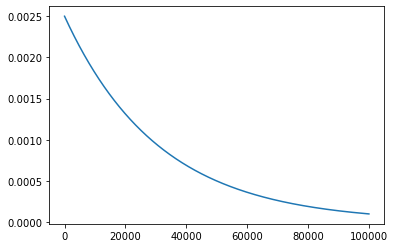

In [11]:
n_batches = int(1e5)
starting_lr = 0.0025
min_lr = 0.0001
gamma = math.exp(math.log(min_lr / starting_lr) / n_batches)

result = [starting_lr]
for i in range(n_batches):
    result.append(result[-1] * gamma)
    
plt.plot(result)

In [1]:
import base64
from kaggle_environments.envs.hungry_geese.hungry_geese import Action, Configuration, Observation, histogram, translate, row_col
from kaggle_environments import make as kaggle_make
import numpy as np
from pathlib import Path
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import tqdm

from hungry_geese.nns import models, conv_blocks
from hungry_geese.env.torch_env import TorchEnv
from hungry_geese.mcts.torch_mcts import TorchMCTS
import hungry_geese.env.goose_env as ge
from hungry_geese.mcts.utils import torch_actor_critic_factory
from hungry_geese.utils import torch_terminal_value_func
#device = torch.device('cuda:0')
device = torch.device('cuda:1')

config = Configuration(kaggle_make('hungry_geese', debug=False).configuration)

Loading environment football failed: No module named 'gfootball'


In [40]:
obs_type = ge.ObsType.COMBINED_GRADIENT_OBS_LARGE
n_channels = 92
activation = nn.ReLU
normalize = False
use_mhsa = False
model_kwargs = dict(
    block_class=conv_blocks.BasicConvolutionalBlock,
    block_kwargs=[
        dict(
            in_channels=obs_type.get_obs_spec()[-3],
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize,
            use_mhsa=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize,
            use_mhsa=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize,
            use_mhsa=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize,
            use_mhsa=use_mhsa,
            mhsa_heads=4,
        ),
    ],
    squeeze_excitation=True,
    cross_normalize_value=True,
    use_separate_action_value_heads=True,
    # **ge.RewardType.RANK_ON_DEATH.get_recommended_value_activation_scale_shift_dict()
)
model = models.FullConvActorCriticNetwork(**model_kwargs)
model.load_state_dict(torch.load(Path.home() / 'goose_agent/cp.pt'))
model.to(device)

env_kwargs = dict(
    config=config,
    n_envs=2,
    obs_type=obs_type,
    device=device
)
env = TorchEnv(**env_kwargs)
env_copy = TorchEnv(**env_kwargs)
mcts = TorchMCTS(
    torch_actor_critic_factory(model),
    torch_terminal_value_func,
    100,
    add_noise=True,
    device=device,
    n_envs=env.n_envs,
    max_size=250
)
tree = mcts.tree

FileNotFoundError: [Errno 2] No such file or directory: '/home/isaiah/goose_agent/cp.pt'

In [12]:
n_mcts_iter = 100
while not env.dones.any():
    print(env.step_counters[0].item())
    mcts.reset()
    mcts.run_mcts(env, env_copy, n_mcts_iter, show_progress=True)
    policies = mcts.tree.get_improved_policies()
    policy_max = policies.max(dim=-1, keepdim=True).values
    actions = torch.multinomial(
        (policies == policy_max).view(-1, 4).to(torch.float32),
        1
    ).view(-1, env.n_geese)
    env.step(torch.where(
        env.alive,
        actions,
        torch.zeros_like(actions)
    ))
    obs_dict = env.generate_obs_dicts()
    for env_idx in range(env.n_envs):
        assert np.allclose(
            env.obs[env_idx].cpu().numpy(),
            ge.create_obs_tensor(obs_dict[env_idx], env.obs_type)
        )

 36%|███▋      | 4/11 [00:00<00:00, 35.99it/s]

0


 27%|██▋       | 3/11 [00:00<00:00, 26.98it/s]

1


 18%|█▊        | 2/11 [00:00<00:00, 16.88it/s]

2


 18%|█▊        | 2/11 [00:00<00:00, 17.28it/s]

3


 36%|███▋      | 4/11 [00:00<00:00, 37.91it/s]

4


100%|██████████| 11/11 [00:00<00:00, 33.37it/s]


In [7]:
mcts.reset()
env.reset()
profiling_enabled = False
n_mcts_iter = 100
with torch.autograd.profiler.profile(enabled=profiling_enabled, use_cuda=True) as prof:
    mcts.run_mcts(env, env_copy, n_mcts_iter, show_progress=True)
#if profiling_enabled:
#    prof.export_chrome_trace(f'trace_{str(device).split(":")[0]}_{env.n_envs}_envs_{n_mcts_iter}_iter.json')

100%|██████████| 101/101 [00:01<00:00, 51.18it/s]


In [8]:
env_idx = 0
print(env.render_env(env_idx, include_info=True))
mcts.tree.get_improved_policies(1.)[env_idx]

Step: 0
Lengths: [1, 1, 1, 1]
Rewards: [0, 0, 0, 0]

_ _ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ * _ _ C _
_ B _ _ _ D _ _ _ _ _
_ _ _ _ _ _ _ A _ _ _
_ _ _ _ _ _ _ _ _ * _



tensor([[0.1200, 0.7600, 0.0100, 0.1100],
        [0.1200, 0.2800, 0.0100, 0.5900],
        [0.1700, 0.3800, 0.0100, 0.4400],
        [0.3300, 0.5200, 0.0100, 0.1400]])

In [5]:
obs_dict = env.generate_obs_dicts()
obs_dict[0]

[{'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'index': 0,
   'step': 0,
   'geese': [[52], [67], [31], [55]],
   'food': [51, 68]},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'index': 3},
  'status': 'ACTIVE'}]

In [6]:
%timeit env.generate_obs_dicts()

825 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit obs_dict = env.generate_obs_dicts()
obs_dict[0]

16.2 s ± 526 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'obs_dict' is not defined

In [7]:
top_level_events_only = False
if torch.device == torch.device('cpu'):
    print(prof.key_averages().table(sort_by="cpu_time_total", top_level_events_only=top_level_events_only))
else:
    print(prof.key_averages().table(sort_by="cuda_time_total", top_level_events_only=top_level_events_only))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           mcts_backpropagate         0.16%      21.880ms        10.99%        1.473s      14.586ms       8.015ms         0.01%       51.872s     513.587ms           101  
                   aten::item         0.60%      79.913ms         6.04%     810.280ms      85.880us       50.862s        79.20%       51.649s       5.474ms          9435  
             aten::is_nonzero         0.08%      10.221ms         1.49%     200.264ms      92.801us      13.207ms         0.02%       50.96

In [ ]:
test = 

moves = torch.zeros((test.n_envs, test.n_geese), dtype=torch.int64, device=device) + 1
update_mask = torch.ones((test.n_envs,), dtype=torch.bool, device=device)
update_mask[-1] = False

profiling_enabled = False
with torch.autograd.profiler.profile(enabled=profiling_enabled, use_cuda=True) as prof:
    test.reset()
    for i in tqdm.trange(40):
        test.step(moves, update_mask)
print(test.render_env(0, include_info=True))
if profiling_enabled:
    prof.export_chrome_trace(f'trace_{str(device).split(":")[0]}_{test.n_envs}_envs.json')

In [ ]:
print(test.render_env(-1, include_info=True))
test.obs[-1][test.obs_channel_idxs['steps_since_starvation']]

In [ ]:
top_level_events_only = True
if torch.device == torch.device('cpu'):
    print(prof.key_averages().table(sort_by="cpu_time_total"))
else:
    print(prof.key_averages().table(sort_by="cuda_time_total", top_level_events_only=top_level_events_only))

In [ ]:
env_idx = 1
test.geese_tensor[env_idx], test.lengths[env_idx]

In [ ]:
test.dones

In [ ]:
test.geese[sc].shape

In [ ]:
torch.arange(8).view(2, 4) % torch.tensor([2, 3]).view(2, 1)

In [ ]:


test.geese[torch.arange(test.n_envs)[test.dones], :, 0] = 1
test.geese.sum()


In [ ]:

n_rows = 7
n_cols = 11

head_locs = torch.multinomial(
    torch.ones((3, n_rows * n_cols)),
    4
)
loc_to_row_column = torch.tensor(
    [row_col(i, n_cols) for i in range(n_rows * n_cols)],
).view(n_rows * n_cols, 2)
loc_to_row_column[head_locs]

In [ ]:
import kaggle_environments
from kaggle_environments.envs.hungry_geese.hungry_geese import Action, Configuration, Observation

from hungry_geese.utils import read_json
from hungry_geese.env.lightweight_env import make_from_state
import main

In [ ]:
make_from_state(Observation(env.steps[-2][0]['observation']), [Action.NORTH] * 4).done

In [ ]:
len(env.steps)

In [ ]:
replay_dict = read_json('/home/isaiah/Downloads/19998794.json')
env = kaggle_environments.make(
    'hungry_geese',
    configuration=replay_dict['configuration'],
    steps=replay_dict['steps'],
    info=replay_dict['info']
)

conf = env.configuration
env.steps[119][0]['observation']['step'] = 0

main.AGENT = None
main.call_agent(env.steps[119][0]['observation'], conf)
main.call_agent(env.steps[120][0]['observation'], conf)
"""
obs = Observation(Observation(env.steps[120][0]['observation']))
main.AGENT.preprocess(obs, conf)
light_env = make_from_state(obs, main.AGENT.last_actions)
main.AGENT.search_tree.run_batch_mcts(light_env.lightweight_clone(), 1, n_iter=2)
out = main.AGENT.search_tree.expand(light_env)
out"""

In [ ]:
light_env.step_counter

In [ ]:
print(light_env.render_ansi())

In [ ]:
env.render(mode='ipython', height=700, width=800)

In [ ]:
n_geese = 4
values = torch.arange(8).view(2,4).to(torch.float)
still_alive = torch.ones_like(values).to(torch.bool)
still_alive[0,0:2] = False


values.masked_fill_(~still_alive, float('-inf'))
win_probs = torch.softmax(values, dim=-1)
print(win_probs)
remaining_rewards = torch.linspace(0., 1., n_geese, dtype=torch.float)
remaining_rewards_min = remaining_rewards[-still_alive.sum(dim=-1)].unsqueeze(-1)
remaining_rewards_var = 1. - remaining_rewards_min
values = remaining_rewards_min + win_probs * remaining_rewards_var
# TODO: This is a hacky solution - there should be a more elegant way to do this for any n_geese_remaining?
print(values)
values = torch.where(
    still_alive.sum(dim=-1, keepdim=True) == 4,
    values * 2.,
    values
)
values = torch.where(
    still_alive.sum(dim=-1, keepdim=True) == 3,
    values * 1.2,
    values
)

print(values)
max_vals = values.max(dim=-1, keepdim=True)[0]
values = torch.where(
    max_vals > 1.,
    torch.where(
        values == max_vals,
        values - (max_vals - 1.),
        values + (max_vals - 1.) / still_alive.sum(dim=-1, keepdim=True)
    ),
    values
)
print(values)
values * 2. - 1

In [ ]:
DEVICE = torch.device('cuda')

obs_type = ge.ObsType.COMBINED_GRADIENT_OBS
n_channels = 128
activation = nn.ReLU
normalize = False
model_kwargs = dict(
    block_class=models.BasicConvolutionalBlock,
    block_kwargs=[
        dict(
            in_channels=obs_type.get_obs_spec()[-3],
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=normalize
        ),
    ],
    squeeze_excitation=True,
    cross_normalize_value=True,
    # **ge.RewardType.RANK_ON_DEATH.get_recommended_value_activation_scale_shift_dict()
)
model = models.FullConvActorCriticNetwork(**model_kwargs)

In [ ]:
import base64
import copy
from kaggle_environments import make as kaggle_make
from kaggle_environments.envs.hungry_geese.hungry_geese import Action, Configuration, Observation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle
from scipy import special, stats
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from hungry_geese import models
from hungry_geese.utils import ActionMasking
from hungry_geese.env import goose_env as ge
from hungry_geese.env.lightweight_env import LightweightEnv, make_from_state
from hungry_geese.mcts.basic_mcts import BasicMCTS
from hungry_geese.training.alphagoose.alphagoose_data import AlphaGoosePretrainDataset, ToTensor
from hungry_geese.utils import read_json

%matplotlib inline
DEVICE = torch.device('cuda')

In [ ]:
obs_type = ge.ObsType.COMBINED_GRADIENT_OBS
n_channels = 64
activation = nn.ReLU
model_kwargs = dict(
    block_class=models.BasicConvolutionalBlock,
    block_kwargs=[
        dict(
            in_channels=obs_type.get_obs_spec()[-3],
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=False
        ),
        dict(
            in_channels=n_channels,
            out_channels=n_channels,
            kernel_size=3,
            activation=activation,
            normalize=False
        ),
    ],
    squeeze_excitation=True,
    cross_normalize_value=True,
    # **ge.RewardType.RANK_ON_DEATH.get_recommended_value_activation_scale_shift_dict()
)
model = models.FullConvActorCriticNetwork(**model_kwargs)
model.to(device=DEVICE)

run_dir = Path('runs/supervised_pretraining/active/supervised_pretraining_combined_gradient_obs_rank_on_death_none_5_blocks_64_dims_v1/')
with open(run_dir / '0070/cp.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)
model.load_state_dict(loaded_state_dicts)

def action_mask_func(state):
    return ActionMasking.LETHAL.get_action_mask(state)
    
def terminal_value_func(state):
    agent_rankings = stats.rankdata([agent['reward'] for agent in state], method='average') - 1.
    ranks_rescaled = 2. * agent_rankings / (len(state) - 1.) - 1.
    return ranks_rescaled
    
def actor_critic_func(state):
    geese = state[0]['observation']['geese']
    n_geese = len(geese)
    
    obs = ge.create_obs_tensor(state, obs_type)
    head_locs = [goose[0] if len(goose) > 0 else -1 for goose in geese]
    still_alive = [agent['status'] == 'ACTIVE' for agent in state]
    with torch.no_grad():
        logits, values = model(torch.from_numpy(obs),
                               torch.tensor(head_locs).unsqueeze(0),
                               torch.tensor(still_alive).unsqueeze(0))
    
    # Score the dead geese
    dead_geese_mask = np.array([len(goose) for goose in geese]) == 0
    agent_rankings = stats.rankdata([agent['reward'] for agent in state], method='average') - 1.
    agent_rankings_rescaled = 2. * agent_rankings / (n_geese - 1.) - 1.
    
    logits = F.softmax(logits, -1)
    final_values = np.where(
        dead_geese_mask,
        agent_rankings_rescaled,
        values.squeeze(0).numpy()
    )
    
    # Logits should be of shape (4, 4)
    # Values should be of shape (4, 1)
    return logits.squeeze(0).numpy().astype(np.float), final_values[:, np.newaxis]

In [ ]:
with open(run_dir / 'train_episodes.txt', 'r') as f:
    train_episodes = [replay_name.rstrip() for replay_name in f.readlines()]
    train_episodes = set(train_episodes)
with open(run_dir / 'test_episodes.txt', 'r') as f:
    test_episodes = [replay_name.rstrip() for replay_name in f.readlines()]
    test_episodes = set(test_episodes)

dataset_loc = Path('/home/isaiah/data/alphagoose_data_1000/')
train_dataset = AlphaGoosePretrainDataset(
    dataset_loc,
    ge.ObsType.COMBINED_GRADIENT_OBS,
    transform=ToTensor(),
    include_episode=lambda x: x.stem in train_episodes
)
test_dataset = AlphaGoosePretrainDataset(
    dataset_loc,
    ge.ObsType.COMBINED_GRADIENT_OBS,
    transform=ToTensor(),
    include_episode=lambda x: x.stem in test_episodes
)
dataloader_kwargs = dict(
    batch_size=512,
    shuffle=True,
    num_workers=6,
    pin_memory=True
)
train_dataloader = DataLoader(train_dataset, **dataloader_kwargs)
test_dataloader = DataLoader(test_dataset, **dataloader_kwargs)

In [ ]:
def compute_losses(
        state,
        action,
        result,
        head_locs,
        still_alive,
        reduction='mean',
        get_preds=False
):
    with amp.autocast():
        logits, value = model(state, head_locs, still_alive)

        logits_masked = logits.view(-1, 4)[still_alive.view(-1, 1).expand(-1, 4)].view(-1, 4)
        action_masked = action.view(-1)[still_alive.view(-1)]
        policy_loss = F.cross_entropy(logits_masked, action_masked, reduction=reduction)

        value_masked = value.view(-1)[still_alive.view(-1)]
        result_masked = result.view(-1)[still_alive.view(-1)]
        value_loss = F.mse_loss(value_masked, result_masked, reduction=reduction)

        probs_masked = F.softmax(logits_masked, dim=-1)
        entropy_loss = torch.sum(probs_masked * torch.log(probs_masked), dim=-1)
        if reduction == 'none':
            pass
        elif reduction == 'mean':
            entropy_loss = entropy_loss.mean()
        elif reduction == 'sum':
            entropy_loss = entropy_loss.sum()
        else:
            raise ValueError(f'Unrecognized reduction: {reduction}')

        combined_loss = policy_loss + value_loss + 0.05 * entropy_loss

    if get_preds:
        return policy_loss, value_loss, entropy_loss, combined_loss, logits_masked.argmax(dim=-1)
    else:
        return policy_loss, value_loss, entropy_loss, combined_loss

test_metrics = {
    'policy_loss': 0.,
    'value_loss': 0.,
    'entropy_loss': 0.,
    'combined_loss': 0.,
    'policy_accuracy': 0.
}
n_test_samples = 0.
with torch.no_grad():
    for test_tuple in tqdm(test_dataloader):
        test_tuple = [t.to(device=DEVICE) for t in test_tuple]
        state, action, result, head_locs, still_alive = test_tuple
        policy_loss, value_loss, entropy_loss, combined_loss, preds = compute_losses(
            *test_tuple,
            reduction='mean',
            get_preds=True
        )
        action_masked = action.view(-1)[still_alive.view(-1)]

        test_metrics['policy_loss'] += policy_loss.detach().cpu().item()
        test_metrics['value_loss'] += value_loss.detach().cpu().item()
        test_metrics['entropy_loss'] += entropy_loss.detach().cpu().item()
        test_metrics['combined_loss'] += combined_loss.detach().cpu().item()
        test_metrics['policy_accuracy'] += preds.eq(action_masked).sum().cpu().item()
        n_test_samples += still_alive.sum().cpu().item()

    for key, metric in test_metrics.items():
        test_metrics[key] = metric / n_test_samples

In [ ]:
# Train metrics
print(test_metrics)

In [ ]:
# Train metrics
print(test_metrics)

In [ ]:
# Test metrics
print(test_metrics)

In [ ]:
# Train metrics
print(test_metrics)

In [ ]:
# Test metrics
print(test_metrics)

In [ ]:
#env = kaggle_make('hungry_geese', debug=True)
#env.reset(num_agents=4);
replay_dict = read_json('/home/isaiah/Downloads/19528131.json')
env = kaggle_make(
    'hungry_geese',
    configuration=replay_dict['configuration'],
    steps=replay_dict['steps'],
    info=replay_dict['info']
)
env.render(mode='ipython', height=700, width=800)

In [ ]:
search_tree = BasicMCTS(
    action_mask_func=action_mask_func,
    actor_critic_func=actor_critic_func,
    terminal_value_func=terminal_value_func,
    c_puct = 1.,
    include_food=False
)
step_idx = 120
state = env.steps[step_idx][0]
state.update(env.steps[step_idx][0]['observation'])
obs = Observation(state)
light_env = make_from_state(
    obs,
    [Action[agent['action']] for agent in env.steps[-1]],
    env.configuration
)
print(light_env.render_ansi())

root_node = search_tree.run_mcts(
    env=light_env,
    n_iter=10000,
    max_time=0.5
)
print(root_node.initial_policies)
print(root_node.initial_values)
print(root_node.q_vals)
print(root_node.n_visits / root_node.n_visits.sum(axis=1, keepdims=True))
print(root_node.n_visits.sum(axis=1)[0])

In [ ]:
search_tree = BasicMCTS(
    action_mask_func=action_mask_func,
    actor_critic_func=actor_critic_func,
    terminal_value_func=terminal_value_func,
    c_puct = np.sqrt(2.),
    include_food=False
)
while not env.done:
    state = env.steps[-1][0]
    state.update(env.steps[-1][0]['observation'])
    obs = Observation(state)
    light_env = make_from_state(
        obs,
        [Action[agent['action']] for agent in env.steps[-1]],
        env.configuration
    )
    print(light_env.render_ansi())
    
    csr = light_env.canonical_string_repr(include_food=search_tree.include_food)
    for key in list(search_tree.nodes.keys()):
        if key.startswith(f'S: {obs.step - 1}') or (key.startswith(f'S: {obs.step}') and key != csr):
            del search_tree.nodes[key]
    root_node = search_tree.run_mcts(
        env=light_env,
        n_iter=10000,
        max_time=0.3
    )
    print(root_node.n_visits)
    print(int(root_node.n_visits.sum() / 4))
    actions = root_node.get_improved_actions(0.)
    env.step([tuple(Action)[a].name for a in actions])

In [ ]:
actor_critic_func(env.steps[-12])

In [ ]:
env.render(mode='ipython', height=700, width=800)

In [ ]:
print(root_node.n_visits)
print(int(root_node.n_visits.sum() / 4))
root_node.q_vals

In [ ]:
import matplotlib.colors as colors
for s, a, r, hl, alive in ag_dataloader:
    square = np.ceil(np.sqrt(s.shape[1])).astype(np.int)
    fig, axs = plt.subplots(square, square, figsize=(20,10))
    ix = 0
    for i in range(square):
        for j in range(square):
            ax = axs[i, j]
            ax.set_xticks([])
            ax.set_yticks([])
            eps = 1e-2
            if ix < s.shape[1]:
                pcm = ax.imshow(s[0, ix, :, :] + eps, norm=colors.LogNorm(vmin=eps, vmax=1.), cmap='gray')
                ix += 1
    fig.colorbar(pcm, ax = axs)
    plt.show()
    break